#  Импорт данных


In [1]:
import numpy as np # библиотека Numpy для операций линейной алгебры и прочего
import pandas as pd # Библиотека Pandas для работы с табличными данными

import matplotlib.pyplot as plt # библиотека Matplotlib для визуализации

import seaborn as sns # библиотека seaborn для визуализации

from sklearn.datasets import fetch_openml # функция библиотеки scikit-learn для загрузки данных с сайта OpenML

pd.set_option("display.max_rows", 20)
pd.set_option("display.max_columns", 20)
pd.set_option("display.precision", 6)
pd.set_option("plotting.backend", "matplotlib")
%matplotlib inline

plt.style.use('default')

# Метод главных компонент

## Класс для вычисления собственных векторов и их собственных значений

In [2]:
class PCA():
    def __init__(self, n_components):
        self.n_components = n_components
        self.components = None
        self.values = None
        self.mean = None
    
    def fit(self, X):
        """
        Нахождение собственных значений и собственных векторов
        """

        # оценка среднего для каждого признака
        self.mean = np.mean(X, axis=0)
        
        # Считаем матрицу ковариации, используя функцию библиотеки Numpy
        # не забываем вычитать среднее
        cov_matrix = np.cov(X - self.mean, rowvar = False)

        # считаем собственные значания и собственные вектора матрицы ковариации
        # для этого тоже есть функция Numpy
        eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

        #Сортируем по возрастанию собственных значений
        idx = eigenvalues.argsort()[::-1]
        
        # Берём первые n собственных векторов
        self.components = eigenvectors[:, idx][:, :self.n_components]

        # отсортированные собственные значения
        self.values     = eigenvalues[idx]

        return self
    

    def transform(self, X):
        """
        Преобразование признаков в пространство главных компонент
        """
        #вычитаем среднее
        X = X - self.mean

        #находим проекции признаков на собственные вектора (через скалярное произведение)
        #это и будут главные компоненты
        return np.dot(X, self.components)


    def fit_transform(self, X):
        """
        2 в 1: обучаем и преобразуем
        """
        return self.fit(X).transform(X)


    def inverse_transform(self, X_new):
        """
        Обратное преобразование.
        Главные компоненты скалярно умножаем на собственные вектора
        """

        # не забываем обратно добавить среднее
        return np.dot(X_new, self.components.T) + self.mean

    def show_values(self):
        print( "Eigen_Vectors:")
        print(self.components)
        print("Eigen_Values :")
        print(self.values)

    def score(self, X):
        """
        оцека "качества" восстановления, через коэффициент детерминации
        """

        SStot = np.sum(np.square(X - np.mean(X)))
        SSres = np.sum(np.square(X - self.inverse_transform(self.fit_transform(X))))
        S= 1 - SSres/SStot
        print("Score = ", S)
        return S


    def plot_eigvalues(self, figsize=(15,7)):
        """
        метод для отрисовки собственных значений (объясненной дисперсии)
        """

        plt.figure(figsize=figsize)

        # отдельно мелкими точками визуализируем все собственные значения
        plt.plot(self.values,'.',
                 label='Все собственные значения',
                 linewidth = 3)

        # крупными маркерами - выбранное нами количество главных компонент
        plt.plot(self.values[:self.n_components],'r-o',
                 label='Собственное пространство',
                 markersize = 10, mfc='none',
                 linewidth = 2, alpha = 0.8)

        plt.ylabel('Собственные\n значения', fontsize=25)
        plt.grid();
        plt.legend(fontsize=25);
        plt.xticks(fontsize = 25); plt.yticks(fontsize = 25);
        plt.tight_layout();
        plt.show()

In [3]:
def plot_scatter(x,y,title_x = '', title_y = ''):
    fig = plt.figure(figsize=(10,7))
    plt.grid()

    plt.scatter(x,y,
                alpha = 0.5, s = 196,
                c = 'orange', edgecolor = 'r')
    plt.xlabel(title_x,fontsize=25)
    plt.ylabel(title_y,fontsize=25)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15);
    minx=np.min([x.min()*1.2, y.min()*1.2])
    maxx=np.max([x.max()*1.2, y.max()*1.2])
    plt.xlim([minx, maxx])
    plt.ylim([minx, maxx])
    plt.tight_layout();
    plt.show()

# Синтетические данные
## Генерация синтетических данных

### Функция для генерации данных

In [4]:
def create_elipsoid_data(C1 = 0, C2 = 0, S1 = 5, S2 =1, theta =45, N = 250, random_state = 42):
    """
    Генерация набора данных в виде эллипса
    :param C1: координаты центра
    :param C2: координаты центра
    :param S1: радиус эллипса
    :param S2: радиус эллипса
    :param theta: угол наклона
    :param N: количество точек данных
    :param random_state: фиксированный сид случайных чисел (для повторяемости)
    """

    # фиксированный сид случайных чисел (для повторяемости)
    np.random.seed(random_state)
    
    # переводим угл в радианы
    theta = np.pi*theta/180

    # группируем в один вектор
    Centers = np.array([C1,C2]) # центры
    Sigmas = np.array([S1,S2]) # и радиусы эллипса

    # Матрица поворота
    R = np.array([[np.cos(theta), - np.sin(theta)],
                [np.sin(theta), np.cos(theta)]])

    # Генерируем данные
    X = R @ np.diag(Sigmas) @ np.random.randn(2, N)+np.diag(Centers)@ np.ones((2, N))

    # транспонируем чтобы данные были в формате (количество точек, количество признаков)
    X = X.T

    # Визуализируем результат
    plot_scatter(X[:,0],X[:,1],r'$x_1$', r'$x_2$')

    return X

### Генерация с помощью функции

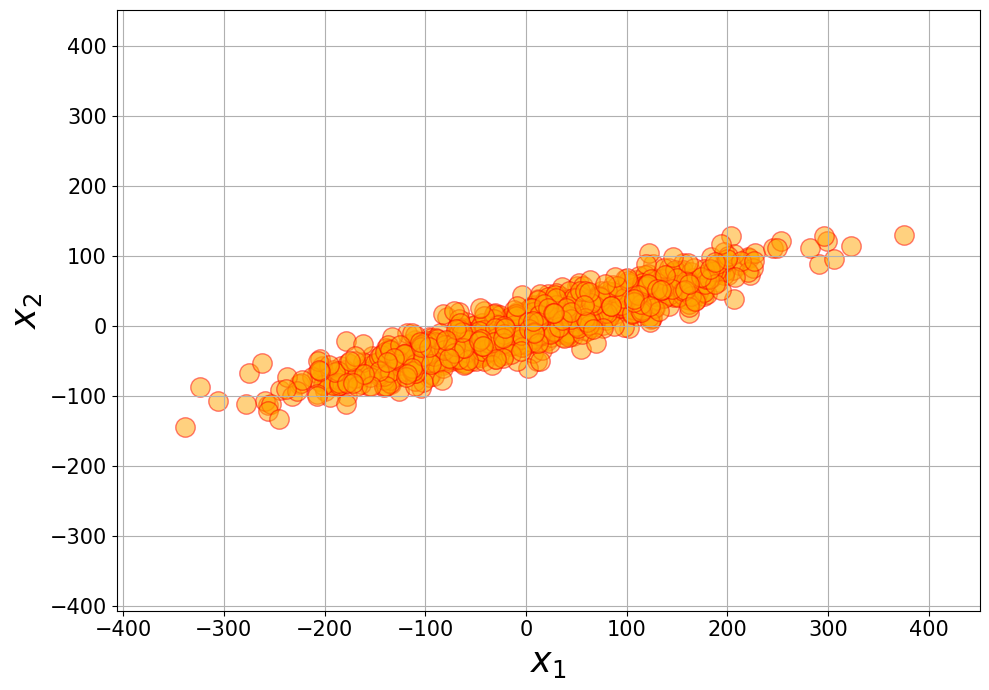

In [5]:
X = create_elipsoid_data(C1 = 0, C2 = 0, S1 = 118, S2 =17, theta =22, N = 1000, random_state = 32)

## Применение метода главных компонент
### Применяем разработанный класс PCA

In [6]:
# Задаем максимально количество компонент
pca = PCA(n_components = 2)
pca.fit(X)
pca.score(X);

Score =  1.0


Коэффициент детерминации R2=1, качество модели отличное

### Собственные значения и собственные вектора

In [7]:
pca.show_values()

Eigen_Vectors:
[[-0.92932734  0.36925695]
 [-0.36925695 -0.92932734]]
Eigen_Values :
[13435.04319854   287.70862484]


### Пространство главных компонент

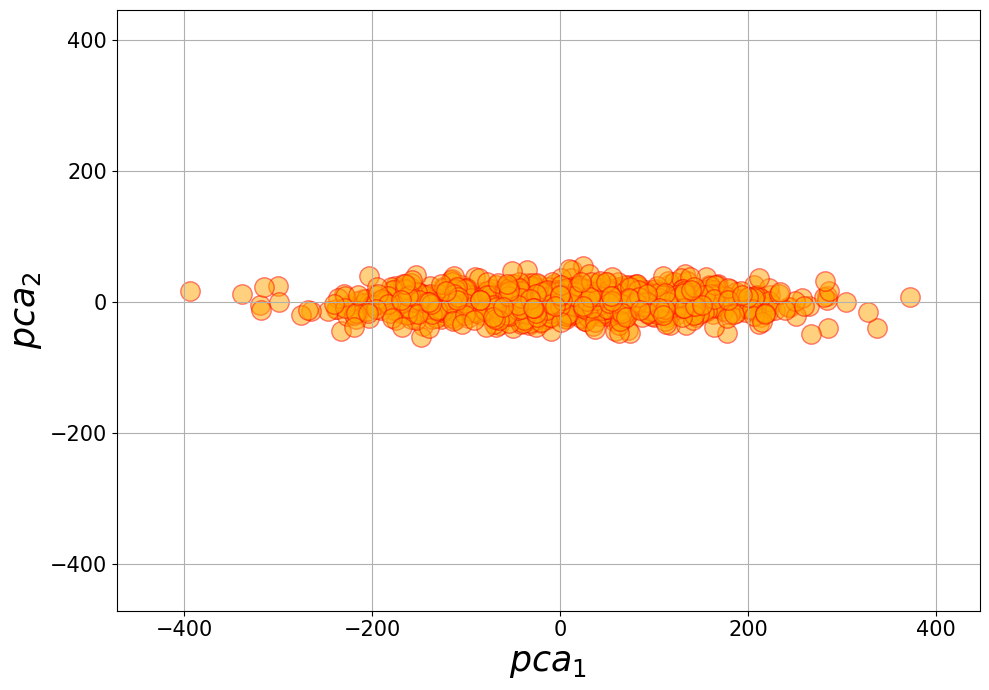

In [8]:
# воспользуемся методом transform
X_new = pca.transform(X)

# И делаем стандартную визуализацию
plot_scatter(X_new[:,0],X_new[:,1],r'$pca_1$', r'$pca_2$')

### Минимальные и максимальные значения в пространстве главных компонент

In [9]:
print("Min(pca_1)=", X_new[:,0].min())
print("Max(pca_1)=", X_new[:,0].max())
print("Min(pca_2)=", X_new[:,1].min())
print("Max(pca_2)=", X_new[:,1].max())

Min(pca_1)= -393.14717074655806
Max(pca_1)= 372.00283495597756
Min(pca_2)= -52.64807939628558
Max(pca_2)= 54.957635718614775


### Визуализация главных компонент с распределением исходных данных

Выполним визуализацию исходных данных, эллипсов полученных из собственных значений и векторов, с поправкой на среднее значение, а также базис из главных компонент

In [10]:
X_mean = np.mean(X, axis = 0)
theta_ = 2 * np.pi * np.arange(0,1,0.01)
X_std = pca.components @ np.diag(np.sqrt(pca.values)) @ np.array([np.cos(theta_),np.sin(theta_)])

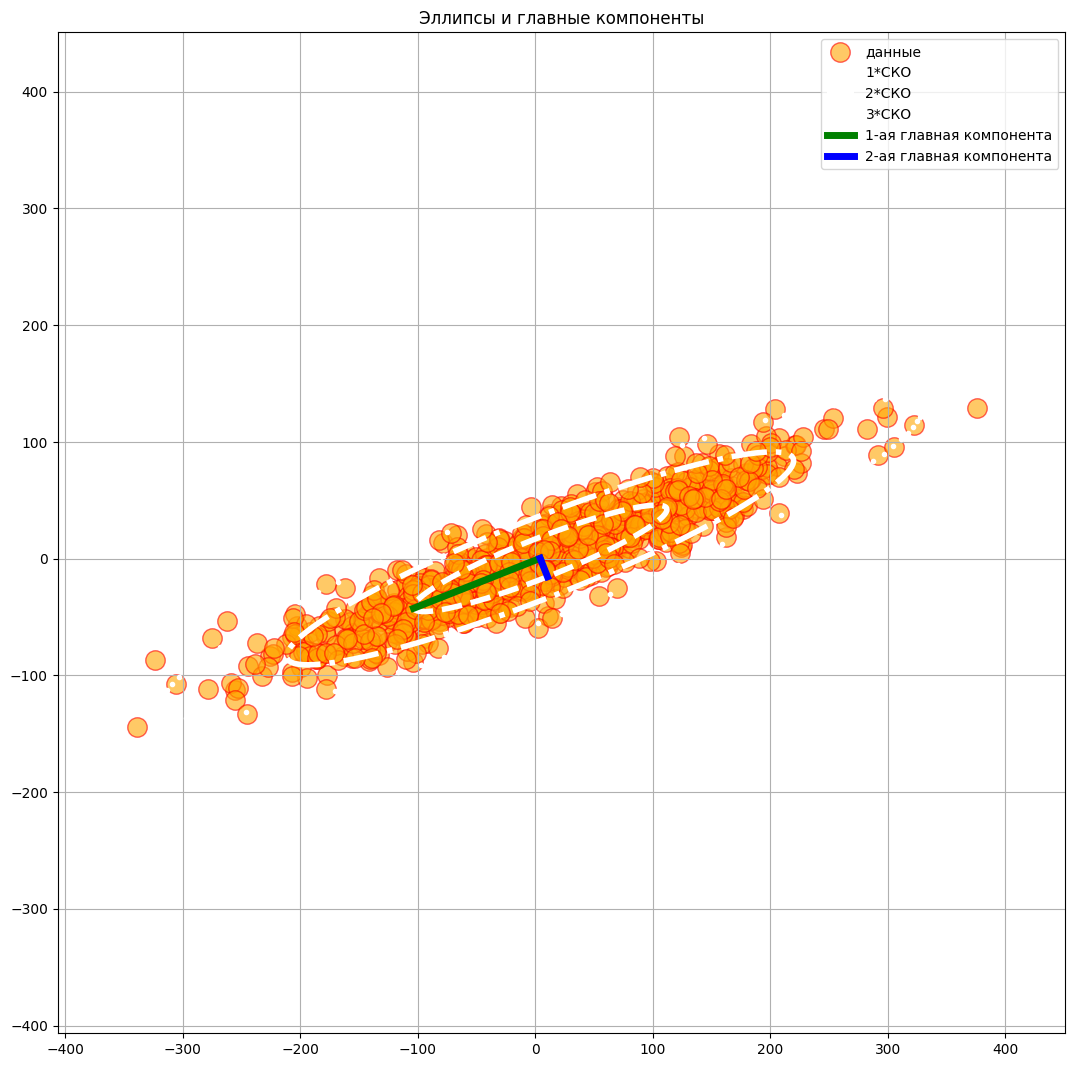

In [11]:
fig = plt.figure(figsize=(13,13))

# рисуем данные
plt.scatter(X[:,0],X[:,1], alpha = 0.6, label = 'данные',s = 196, c = 'orange', edgecolor = 'r')

# рисуем эллипс с "диаметром" ~ 1*СКО
plt.plot(X_std[0,:]+X_mean[0],X_std[1,:]+X_mean[1], 
         '--', c = 'w', linewidth = 4, label = '1*СКО')

#рисуем эллипс с "диаметром" ~ 2*СКО
plt.plot(2*X_std[0,:]+X_mean[0],2*X_std[1,:]+X_mean[1],
         '-.', c = 'w', linewidth = 4, label = '2*СКО')

#рисуем эллипс с "диаметром" ~ 3*СКО
plt.plot(3*X_std[0,:]+X_mean[0],3*X_std[1,:]+X_mean[1],
         '.', c = 'w', linewidth = 4, label = '3*СКО')

# 1-ая главная компонента
plt.plot(np.array([X_mean[0], X_mean[0]+pca.components[0,0]*np.sqrt(pca.values[0])]),
         np.array([X_mean[1], X_mean[1]+pca.components[1,0]*np.sqrt(pca.values[0])]),
         'g',linewidth = 5, label = '1-ая главная компонента')

# 2-ая главная компонента
plt.plot(np.array([X_mean[0], X_mean[0]+pca.components[0,1]*np.sqrt(pca.values[1])]),
         np.array([X_mean[1], X_mean[1]+pca.components[1,1]*np.sqrt(pca.values[1])]),
         'b',linewidth = 5, label = '2-ая главная компонента')

# Границы
minx=np.min([X[:,0].min()*1.2, X[:,1].min()*1.2])
maxx=np.max([X[:,0].max()*1.2, X[:,1].max()*1.2])
plt.xlim([minx, maxx])
plt.ylim([minx, maxx])

plt.title('Эллипсы и главные компоненты')
plt.legend()
plt.grid()

Анализ графика показывает, что внутренний эллипс содержит в себе распределение 68% от всех точек (1 стандартное отклонение от среднего).

Внешний эллипс содержит 95% точек (2 стандартных оклонений от среднего).

# Набор данных MNIST

## Загрузка данных с сайта OpenML

In [12]:
# mnist_784 - имя набора данных и версия
# return_X_y=True - чтобы скачалось в формате признаки/целевые метки
# as_frame = True - выгрузить данные в формате dataframe
X, y  = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame = True)

In [13]:
xmax=X.values.max()
xmax

255.0

In [14]:
# нормализуем данные - из диапазона от 0 до 255 в диапазон от 0 до 1
X = X / xmax

# отдельно сохраним данные в формате numpy
X_ = X.values

## Визулизация исходных данных

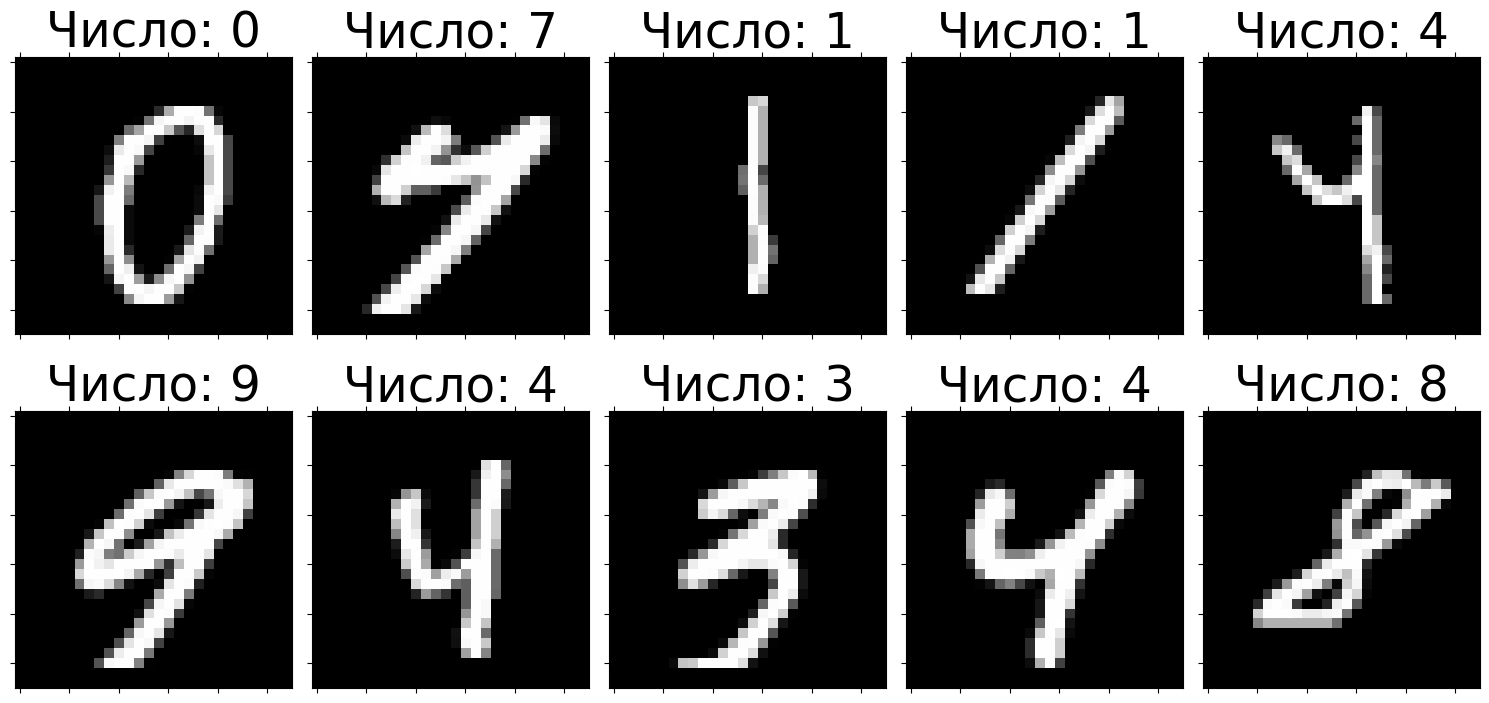

In [15]:
n =  1000

# создаем полотно, на котором визуализируем 10 примеров изображений
fig = plt.figure( figsize=(15,8) )

# начиная с индекса n
for i in range(0,10):
    ax = fig.add_subplot(2,5,i+1) 

    # пишем какое число должно быть
    ax.set_title("Число: {}".format(str(y[i+n]) ), size=35)

    # отрисовываем с помощью функции matshow
    # для этого нам вектор-строку из 784 элементов нужно преобразовать в матрицу 28 на 28
    ax.matshow(1-X.loc[i+n,'pixel1':'pixel784'].values.reshape((28,28)).astype(float),
                cmap='Greys')
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)
    plt.tight_layout()


## Применение метода главных компонент к данным MNIST

### Качество восстановления

Качество восстановления при разных значениях размерности

In [16]:
n_components = np.array([10, 25, 50, 75,100, 125, 150, 200, 250, 300, 350, 400, 450, 500])
scores = np.zeros(n_components.shape, dtype = float)

for i, n_component in enumerate(n_components):
    pca = PCA(n_components = n_component)
    pca.fit(X_)
    scores[i] = pca.score(X_)

Score =  0.6387523030501321
Score =  0.7828861940728367
Score =  0.8765399507043385
Score =  0.9175067378074433
Score =  0.9398662110143557
Score =  0.9538738805709148
Score =  0.9635915926454999
Score =  0.9763374809449328
Score =  0.9845612996952811
Score =  0.9902966800896001
Score =  0.9943369943567654
Score =  0.9970657625500468
Score =  0.9986633478060082
Score =  0.9994749855006912


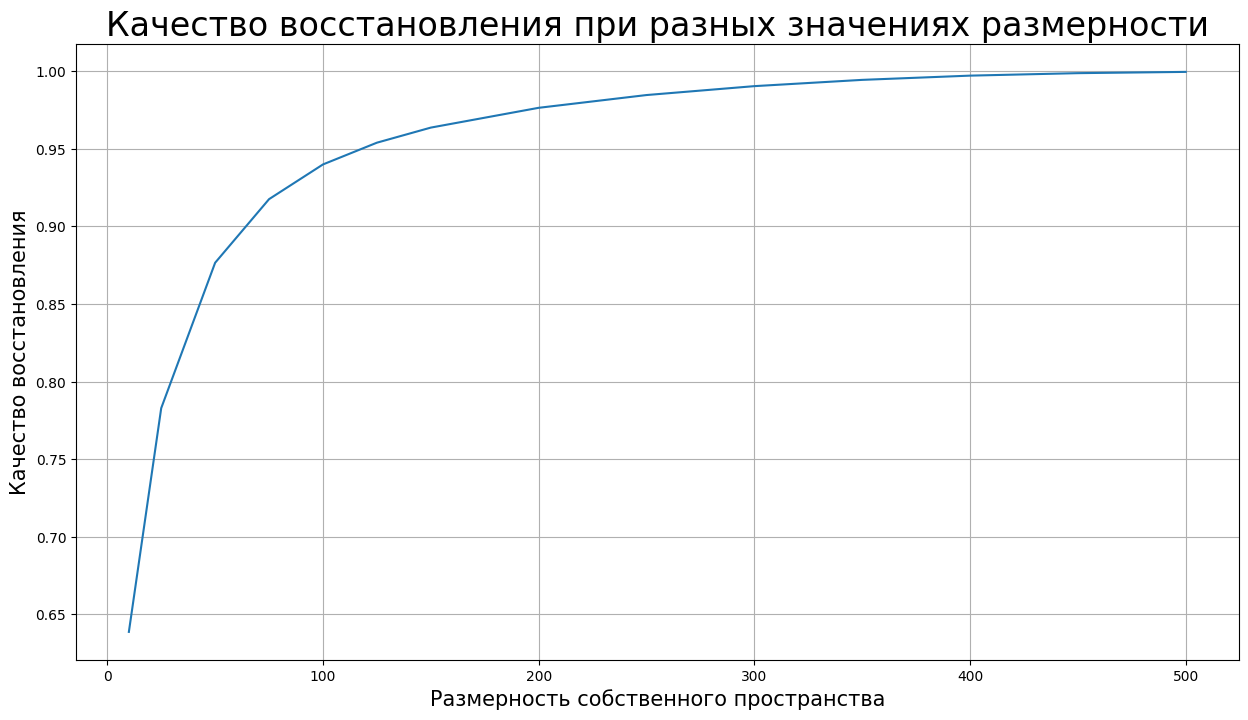

In [17]:
plt.figure(figsize=(15,8) )
plt.plot(n_components, scores)
plt.xlabel('Размерность собственного пространства', fontsize=15)
plt.ylabel('Качество восстановления', fontsize=15)
plt.title("Качество восстановления при разных значениях размерности", fontsize=24)
plt.grid()
plt.show()

Вывод: с увеличением числа компонент качество восстановления возрастает. Если принять приемлемым качество не менее 0.95, то минимальное количество компонент будет:

In [18]:
id = np.where(scores >= 0.95)[0].min()
n_component = n_components[id]
n_component

125

Пересчитаем главные компоненты с этим значением:

In [19]:
# Качество восстановления при 125 компонентах
pca = PCA(n_components = n_component)
pca.fit(X_)
pca.score(X_)

Score =  0.9538738805709148


0.9538738805709148

Оцениваем пространство главных компонент

In [20]:
pca_result_mnist = pca.transform(X_)

In [21]:
# Сохранение DataFrame в файл
pd.DataFrame(pca_result_mnist).to_csv('./content/pca_result_mnist.csv',index=False)

Восстанавливаем исходные изображения из 125 главных компонент

In [22]:
pca_inverse = pca.inverse_transform(pca_result_mnist)
pca_inverse.shape

(70000, 784)

Вывод: размерность восстановленного изображения верная

## Визуализация

### Собственные значения

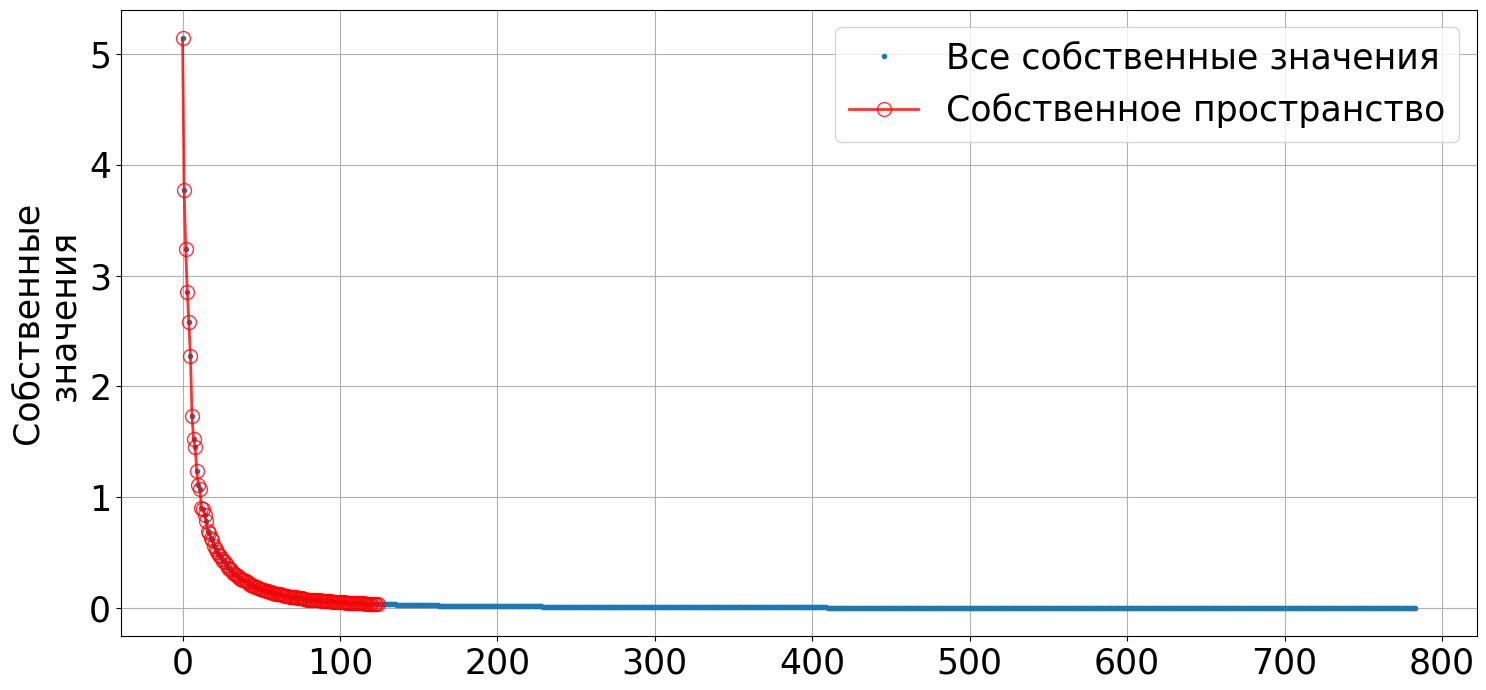

In [23]:
pca.plot_eigvalues();

### Двумерные проекции многомерных данных

In [24]:
def plot_multi(data, y,  names):
    """
    Нескольких двумерных проекций многомерных данных
    :param data: данные
    :param y: целевые метки
    :param names: подписи к осям
    """

    # собираем оси данных, которые мы визуализируем
    axis = [[0,1],
            [2,1],
            [0,3],
            [2,3],]

    # собираем подписи к осям в нужном порядке
    labels = [['',names[1]],
            ['',''],
            [names[0],names[3]],
            [names[2],'']]

    # создаем полотно 2 на 2 
    fig, sub = plt.subplots(2, 2, figsize = (11,11)) 

    # в каждом графике этого полотна мы визуализируем соответсвующие проекции
    for n, (axi, label, ax) in enumerate(zip(axis,  labels, sub.flatten())):
        # визуализация - стандартная скатерограмма
        scatter = ax.scatter(data[:,axi[0]],data[:,axi[1]],
                             c=y,  # разные метки будут подсвечены разным цветом 
                             s = 36, cmap = 'tab10',
                             alpha = 0.7, facecolors = 'none' );
        ax.set_ylabel(label[1], fontsize = 20)
        ax.set_xlabel(label[0], fontsize = 20)
        ax.tick_params(axis='x', labelsize= 15)
        ax.tick_params(axis='y', labelsize= 15)     
        ax.grid()
        ax.set_xlim([-10,12])
        ax.set_ylim([-8,8])
        legend1 = ax.legend(*scatter.legend_elements(),
                        loc="upper right", title="Цифры",
                        fontsize = 15) # собираем легенду
        ax.add_artist(legend1)

#Генерируем подписи к осям
pca_names = [str(x+1)+'-я главная компонента' for x in range(4)]

Некоторые вариации 4 проекций первых главных компонент

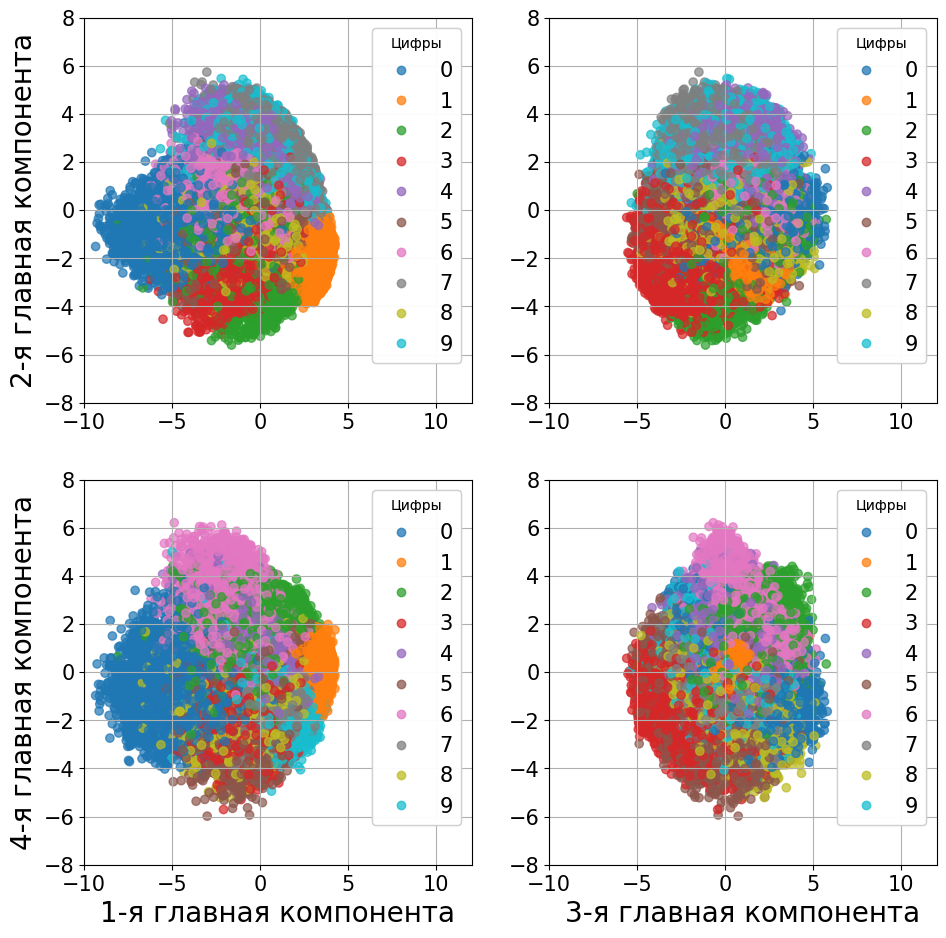

In [25]:
plot_multi(pca_result_mnist, y.astype(int), pca_names);

### В пространстве главных компонент для данных MNIST определите, каким цифрам соответствуют точки со следующими координатами
    • PCA-1 -7; PCA-2 0; - цифра 0
    • PCA-1 4; PCA-4 1;  - цифра 1
    • PCA-3 0; PCA-4 5; - цифра 6
    • PCA-3 -4; PCA-2 -3 - цифра 3

### Восстановление данных

Сравним восстановленные изображения с исходными. Для сравнения добавим восстановление изображения с 65 компонентами:

In [26]:
# Качество восстановления при 65 компонентах
pca_1 = PCA(n_components = 65)
pca_1.fit(X_)
pca_1.score(X_)
pca_result_mnist_1 = pca_1.transform(X_)
pca_inverse_1 = pca_1.inverse_transform(pca_result_mnist_1)


Score =  0.9043091630908444


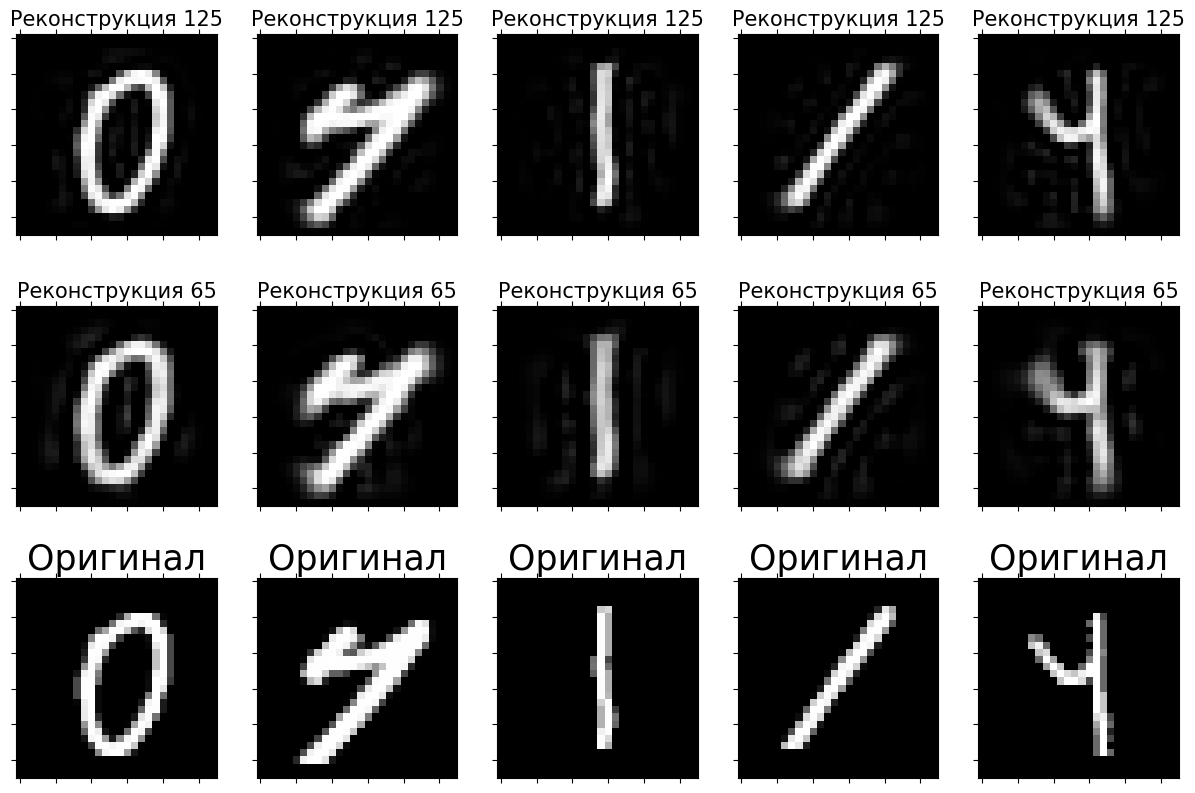

In [27]:
fig=plt.figure(figsize=(15,10))
for i in range(0,5):
  ax = fig.add_subplot(3,5,i+1)
  ax.set_title("Реконструкция 125", size=15)
  ax.matshow(1-pca_inverse[i+n,:].reshape((28,28)).astype(float),cmap='Greys', vmin = 0, vmax = 1)
  plt.setp(ax.get_xticklabels(), visible=False)
  plt.setp(ax.get_yticklabels(), visible=False)

for i in range(0,5):
  ax = fig.add_subplot(3,5,i+6)
  ax.set_title("Реконструкция 65", size=15)
  ax.matshow(1-pca_inverse_1[i+n,:].reshape((28,28)).astype(float),cmap='Greys', vmin = 0, vmax = 1)
  plt.setp(ax.get_xticklabels(), visible=False)
  plt.setp(ax.get_yticklabels(), visible=False)

for i in range(0,5):
  ax = fig.add_subplot(3,5,i+11)
  ax.set_title("Оригинал", size=25)
  ax.matshow(1-X_[i+n,:].reshape((28,28)).astype(float),cmap='Greys', vmin = 0, vmax = 1)
  plt.setp(ax.get_xticklabels(), visible=False)
  plt.setp(ax.get_yticklabels(), visible=False)

Вывод: качество восстановленных изображений немного упало, и чем меньше размерность собственного пространства, тем качество восстановления хуже.


### Визуализация собственных векторов

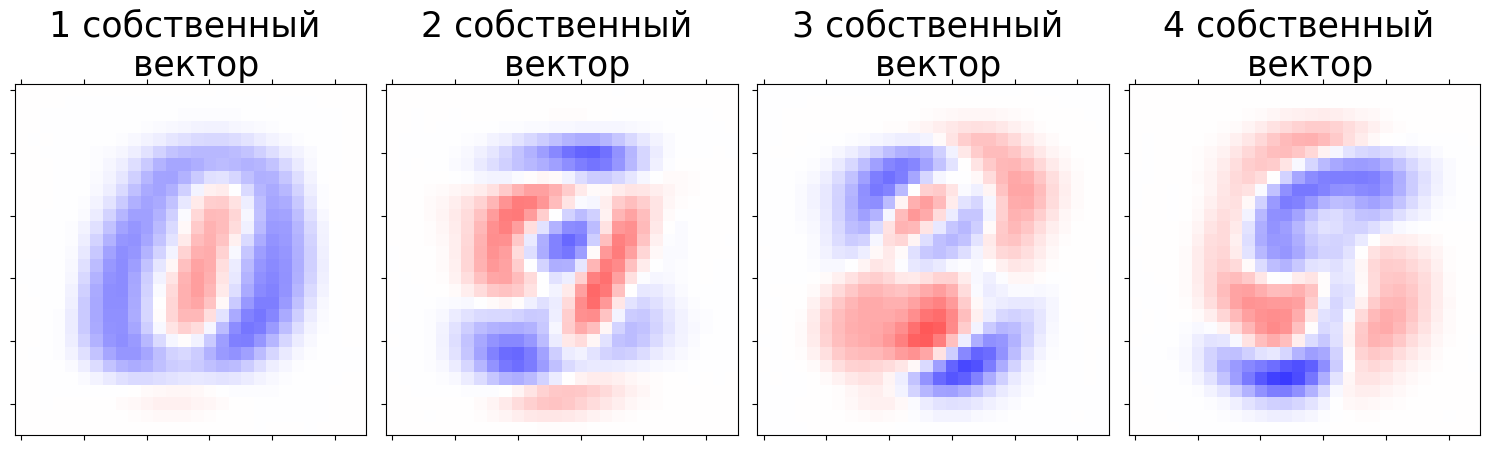

In [28]:
W_pca=pca.components.T
fig=plt.figure(figsize=(15,5))
for i in range(0,4):
  ax = fig.add_subplot(1,4,i+1,title=str(i+1) )
  ax.set_title("{} собственный \n вектор".format(str(i+1)), size=25)
  ax.matshow(W_pca[i].reshape((28,28)).astype(float), cmap = 'bwr', vmin=-0.20,vmax = 0.20)
  plt.setp(ax.get_xticklabels(), visible=False)
  plt.setp(ax.get_yticklabels(), visible=False)
plt.tight_layout();

In [29]:
pca.components.shape

(784, 125)

### Веса исходных признаков в 125первых главных

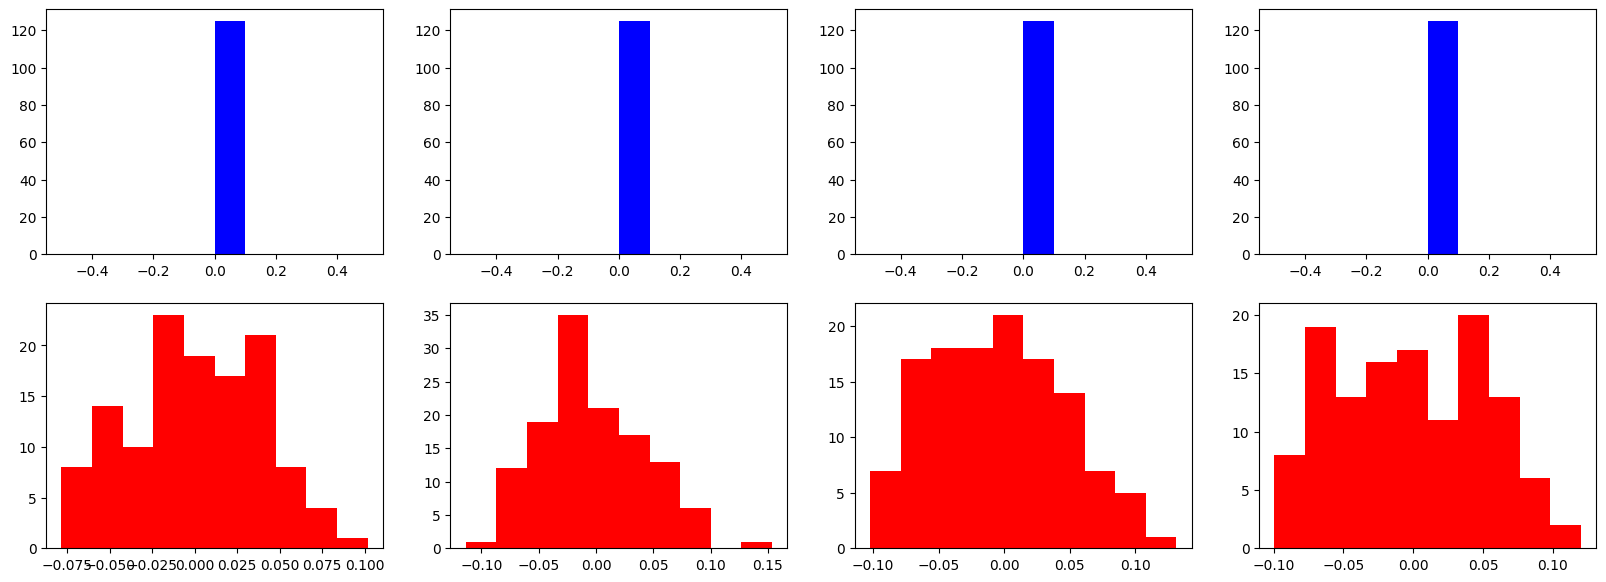

In [30]:
fig = plt.figure(figsize = (20,7))

plt.subplot(241)
plt.hist(pca.components[0,:],color='b')

plt.subplot(242)
plt.hist(pca.components[1,:],color='b')

plt.subplot(243)
plt.hist(pca.components[2,:],color='b')

plt.subplot(244)
plt.hist(pca.components[3,:],color='b')

plt.subplot(245)
plt.hist(pca.components[370,:],color='r')

plt.subplot(246)
plt.hist(pca.components[371,:],color='r')

plt.subplot(247)
plt.hist(pca.components[372,:],color='r')

plt.subplot(248)
plt.hist(pca.components[373,:],color='r');
